# AML analysis notebook

In [1]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.metrics import f1_score
import os
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt


In [2]:
aml = pd.read_csv('../Data/AML_benchmark.csv')

Dropping non-gated labeled cells as in paper

In [3]:
aml = aml.loc[aml['cell_type'] != 'NotDebrisSinglets']

aml = aml.drop(axis='columns', labels=["Time", "Cell_length", "DNA1", "DNA2",
                                       "Viability", "file_number", "event_number", "subject"])
amllabels = pd.DataFrame(aml['cell_type'])

aml = aml.drop(axis='columns', labels="cell_type")
aml.shape

(104184, 32)

arcsinh(5) transform

In [4]:
aml = np.arcsinh((aml-1)/5)
aml.head(5)

,CD45RA,CD133,CD19,CD22,CD11b,CD4,CD8,CD34,Flt3,CD20,...,CD44,CD38,CD13,CD3,CD61,CD117,CD49d2,HLA-DR,CD64,CD41
0,-0.036582,-0.227619,-0.205252,-0.133169,-0.207688,0.170835,0.337530,-0.211231,0.171368,-0.182093,...,3.109508,1.297783,-0.160746,-0.230554,-0.201568,-0.146402,0.701901,1.588788,-0.203959,-0.200613
1,0.534466,-0.236090,-0.214995,-0.125195,0.651745,-0.233309,-0.209026,-0.110190,4.196187,0.007353,...,3.432093,3.435623,1.365302,-0.241136,1.148348,-0.109998,-0.000889,0.306797,-0.054652,0.717917
2,0.427726,-0.230183,-0.125746,-0.240661,-0.200534,-0.207293,-0.204210,-0.226772,-0.223618,-0.228663,...,4.122663,1.425848,0.015210,0.125988,0.059944,-0.153162,2.556279,1.202985,-0.209427,-0.208891
3,0.245018,-0.225693,-0.215979,-0.241725,0.569956,-0.217352,-0.143370,-0.225507,-0.235831,0.271560,...,3.521768,4.141659,0.331239,-0.139072,-0.238874,-0.133088,1.236133,-0.058980,-0.211861,-0.224160
4,-0.207321,-0.228313,-0.119208,0.311301,0.982524,0.372641,-0.167895,-0.236689,0.234441,0.134938,...,2.874616,3.701703,0.408337,-0.062343,-0.030587,-0.204789,-0.018087,-0.001385,-0.123445,-0.238239


Train LDA & predict labels with CV-cells (5 fold)

In [5]:
amlpredictions = []
# random state ensures same stratification for training/predicting for eventual evaluation
# training without shuffling data gives BAD results
kfoldsplitter = KFold(n_splits=5, shuffle=True, random_state=1)
for train, test in kfoldsplitter.split(aml):
    classifier = LinearDiscriminantAnalysis()
    testdata = aml.iloc[test].values
    traindata = aml.iloc[train].values
    trainlabels = amllabels.iloc[train].values.ravel()
    #train classifier
    classifier.fit(traindata, trainlabels)
    #predict labels
    prediction = classifier.predict(testdata)
    amlpredictions.append(prediction)

/home/paul/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Evaluate AML performance

In [6]:
F1list = []
logplotF1list = []
Acclist = []
batch = 0
for train, test in kfoldsplitter.split(aml):
    #select true labels
    true = amllabels.iloc[test].values.ravel()
    #select predicted labels
    predicted = amlpredictions[batch]
    #calculate evaluation metrics
    F1list.append(metrics.f1_score(true, predicted, average='weighted'))
    logplotF1list.append(metrics.f1_score(true, predicted, average=None, labels=list(set(amllabels.values.ravel()))))
    Acclist.append(metrics.accuracy_score(true, predicted))
    batch += 1


## Evaluation metrics


In [7]:
#increase plotsize
plt.rcParams['figure.figsize'] = [15, 8]

In [8]:
F1median = np.median(F1list)
Accmean = np.mean(Acclist) * 100
Accstd = np.std(Acclist) * 100
print('AML CV-cells')
print('Accuracy mean: %s' % round(Accmean, 2))
print('Accuracy std: %s' % round(Accstd, 2))
print('F1 median: %s' % round(F1median, 2))

AML CV-cells
Accuracy mean: 98.13
Accuracy std: 0.1
F1 median: 0.98


Contents of F1list from which the median is drawn

In [9]:
F1list

[0.9811113249956617,
 0.9830292093687704,
 0.9803931136945024,
 0.980985114002782,
 0.9822042556197944]

In [10]:
print('correct F1 median:')
np.median(np.sum(logplotF1list, axis=0)/5)

correct F1 median:


0.9466505773009409

Plot barplot

In [11]:
#prepare barplot counts
amlpredictions = np.hstack(amlpredictions)
unique, counts = np.unique(amlpredictions, return_counts=True)
amlcountspredicted = dict(zip(unique, counts))
unique, counts = np.unique(amllabels['cell_type'], return_counts=True)
amlcountstrue = dict(zip(unique, counts))



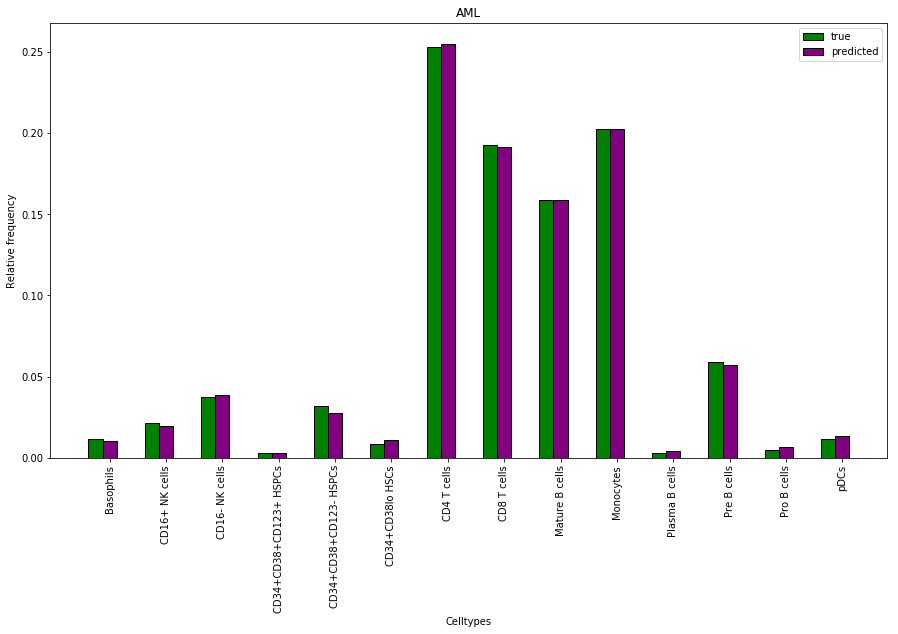

In [12]:
barWidth = 0.25
# set height of bars
bars = [[dictionary[key] for key in dictionary] for dictionary in [amlcountstrue, amlcountspredicted]]
for x in range(len(bars)):
    total = sum(bars[x])
    for y in range(len(bars[x])):
        bars[x][y] = bars[x][y] / total
#set bar x coords
r1 = np.arange(len(list(amlcountstrue.keys())))
r2 = r1 + 0.25
#plot bars & ticks
plt.bar(r1, bars[0], color='green', width=barWidth, edgecolor='black', label='true')
plt.bar(r2, bars[1], color='purple', width=barWidth, edgecolor='black', label='predicted')
plt.xticks([r + barWidth for r in range(len(bars[0]))], list(amlcountstrue.keys()), rotation='vertical')
plt.xlabel("Celltypes")
plt.ylabel("Relative frequency")
plt.title("AML")
plt.legend()
plt.show()

Draw logplot

In [13]:
#prepare logplot data
logplotdf = pd.DataFrame(logplotF1list)
logplotdf.columns = set(amllabels.values.ravel())
logplotdict = dict(logplotdf.mean())
for key in amlcountspredicted:
    logplotdict[key] = [logplotdict[key], np.log10(amlcountspredicted[key])]




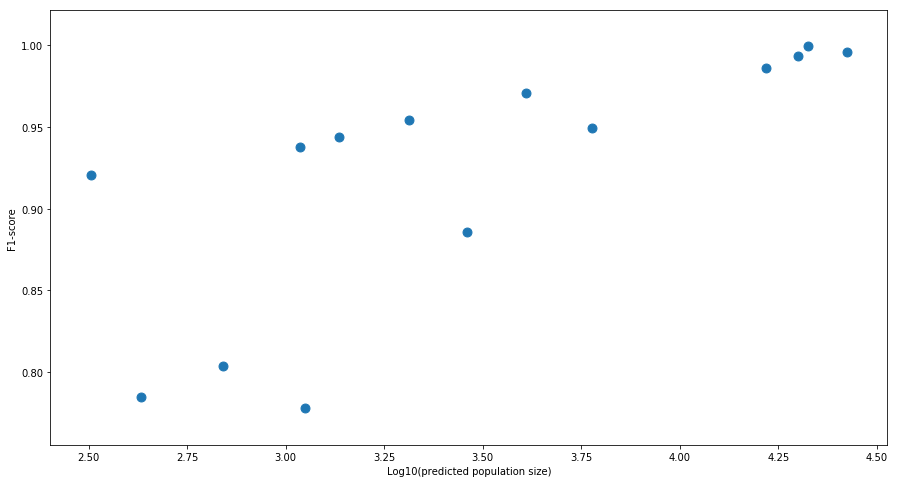

In [14]:
#generate logplot
x = [logplotdict[i][1] for i in logplotdict]
y = [logplotdict[i][0] for i in logplotdict]
plt.xlabel('Log10(predicted population size)')
plt.ylabel('F1-score')
plt.scatter(x, y, s=80)
plt.rc('axes', axisbelow=True)

plt.show()